In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

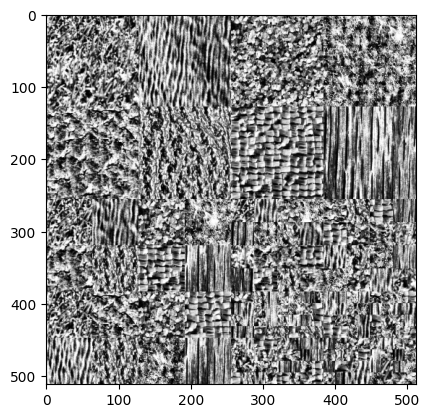

In [2]:
img_ind = 0
image_paths = sorted(list(Path("images").glob("*p512.tiff")))
image_path = image_paths[img_ind]
img = Image.open(image_path).convert("RGB")
plt.imshow(img)

In [53]:
logits = np.load('tmp/c1logits.npy')

In [54]:
# Compute the initial assignment: the channel with highest logit for each pixel
argmaxes = np.argmax(logits, axis=0)  # shape: (H, W)

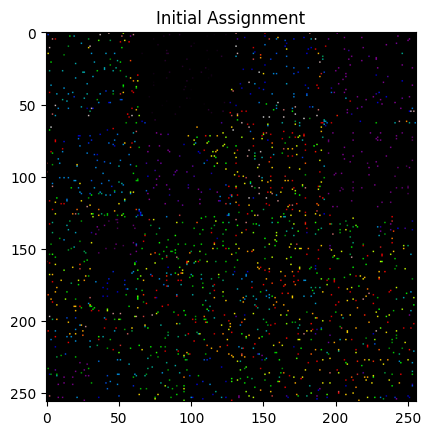

In [55]:
# Assume logits is a numpy array of shape (C, H, W)
C, H, W = logits.shape

# Dictionary to hold seed information for each channel.
# The seed is defined by its coordinates and the logit value at that location.
labels = np.ones_like(argmaxes) * -1  # Initialize labels with -1

for c in range(C):
    # Get a boolean mask for pixels where channel c is the argmax.
    mask = (argmaxes == c)
    
    if np.any(mask):
        # For pixels in region c, get the corresponding logits (for channel c)
        channel_logits = logits[c]
        
        # Find the maximum logit value in the region where channel c is the argmax.
        max_val = np.max(channel_logits[mask])
        
        # Find the coordinates (first occurrence) of this maximum in the masked region.
        # np.argwhere returns coordinates in order [row, column] (i.e. [i, j])
        max_coords = np.argwhere((channel_logits == max_val) & mask)
        if max_coords.shape[0] > 0:
            # use the first occurrence as the seed for channel c
            seed_coords = tuple(max_coords[0])
            labels[seed_coords] = c

plt.figure()
plt.title("Initial Assignment")
plt.imshow(labels+1, cmap='nipy_spectral')

initial_assignment = labels.copy()
# Save the initial assignment


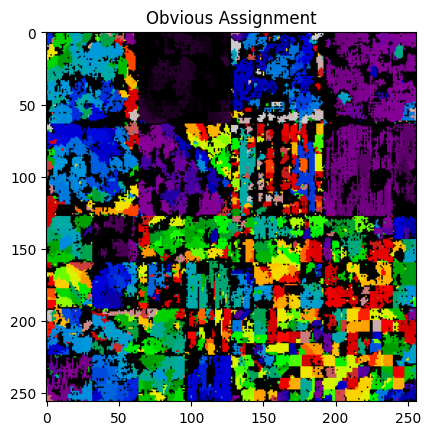

In [57]:
# now we expand without ambiguity, this is, for each pixel we take the max label if it has a contiguous pixel (4-cont) 
from collections import deque

# Assume labels is a numpy array of shape (H, W) where seeds have been assigned
# (non-assigned pixels are -1), argmaxes is a numpy array of shape (H, W),
# and logits is a numpy array of shape (C, H, W)

H, W = labels.shape

# Initialize a queue with all seed pixels (i.e. pixels already assigned)
queue = deque()
for i in range(H):
    for j in range(W):
        if initial_assignment[i, j] != -1:
            queue.append((i, j))

# Define 4-connected neighbor offsets
neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]

while queue:
    i, j = queue.popleft()
    current_label = labels[i, j]
    for di, dj in neighbors:
        ni, nj = i + di, j + dj
        if 0 <= ni < H and 0 <= nj < W:
            # Expand only into unassigned pixels that share the same argmax as the current label.
            if labels[ni, nj] == -1 and argmaxes[ni, nj] == current_label:
                labels[ni, nj] = current_label
                queue.append((ni, nj))

plt.figure()
plt.title("Obvious Assignment")
plt.imshow(labels+1, cmap='nipy_spectral')
obvious_assignment = labels.copy()


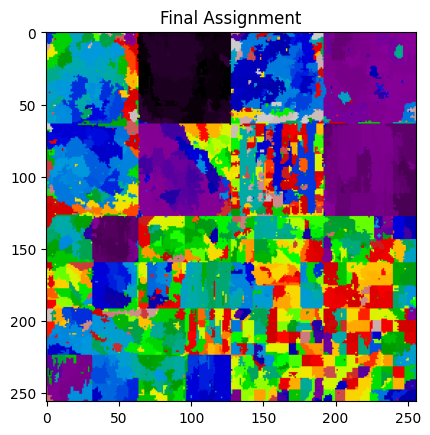

In [58]:
import numpy as np
import heapq

# Assume:
#   labels is a numpy array of shape (H, W) where seeds are labeled
#       with integers in 0..C-1 and unlabeled pixels are -1.
#   logits is a numpy array of shape (C, H, W)
#   argmaxes is a numpy array of shape (H, W)


H, W = labels.shape
C = logits.shape[0]

# Compute per-pixel optimal logit.
max_logits = np.max(logits, axis=0)  # shape: (H, W)

# regret_map stores the regret cost for each pixel.
regret_map = np.full((H, W), np.inf)
for i in range(H):
    for j in range(W):
        if obvious_assignment[i, j] != -1:
            # If the pixel is labeled, its regret is 0 (it was perfectly assigned).
            regret_map[i, j] = 0

def get_neighbors(i, j):
    # 4-connected neighborhood.
    for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        ni, nj = i + di, j + dj
        if 0 <= ni < H and 0 <= nj < W:
            yield ni, nj

def push_candidate(i, j, candidate_label):
    # Use the logits for the candidate contiguous label
    candidate_logit = logits[candidate_label, i, j]
    regret = max_logits[i, j] - candidate_logit
    if regret < regret_map[i, j]:  # if it lowers regret, consider it
        heapq.heappush(pq, (regret, candidate_label, (i, j)))

# Priority queue holds elements: (cumulative_cost, candidate_label, (i, j))
pq = []

# Initialize with seed pixels.
for i in range(H):
    for j in range(W):
        if labels[i, j] != -1:
            for ni, nj in get_neighbors(i, j):
                if labels[ni, nj] == -1:
                    # Push the candidate label for the neighbor.
                    push_candidate(ni, nj, labels[i, j])

# Main loop: process candidates by increasing regret.
while pq:
    regret, cand_label, (i, j) = heapq.heappop(pq)
    if not (regret < regret_map[i, j]) or not (cand_label != labels[i, j]):
        # if it doesn't improve regret or change the label, skip
        continue  
    # else we have a new label with lower regret
    labels[i, j] = cand_label
    regret_map[i, j] = regret
    for ni, nj in get_neighbors(i, j):
        push_candidate(ni, nj, cand_label)

# At the end, labels is fully filled.  Pixels may have been reassigned if a lower cost candidate was found.
plt.figure()
plt.title("Final Assignment")
plt.imshow(labels+1, cmap='nipy_spectral')
final_assignment = labels.copy()


In [64]:
np.save('tmp/superpixels', final_assignment)